In [ ]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client.from_service_account_json('/Users/servandodavidtorresgarcia/servando/relu/gcp/local-catalyst-398309-52645c242657.json')


# Define your table and destination URI
dataset_name = 'thelook_ecommerce'
table_name = 'distribution_centers'
bucket_name = 'ecommerce_looker_download'
destination_uri = f"gs://{bucket_name}/{table_name}.csv"

# Create an extract job
dataset_ref = client.dataset(dataset_name, project='bigquery-public-data')
table_ref = dataset_ref.table(table_name)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location='US',  # Location must match that of the source table.
)
extract_job.result()  # Wait for job to complete

print(f"Exported {dataset_name}.{table_name} to {destination_uri}")


In [26]:

from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

products = DatasetReader(data_folder).get_data_csv('products.csv')
orders = DatasetReader(data_folder).get_data_csv('orders.csv')
order_items = DatasetReader(data_folder).get_data_csv('order_items.csv')
inventory_items = DatasetReader(data_folder).get_data_csv('inventory_items.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
inventory_items.columns

In [ ]:
orders.query("order_id == 18975")

In [ ]:
products.query("id == 19220")

In [ ]:
inventory_items.query("id == 74342")

In [27]:
# Select specific columns from each DataFrame
order_items_selected = order_items[['product_id','order_id','status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price']]
orders_selected = orders[['order_id', 'gender', 'num_of_item']]  # Including 'order_id' for joining
products_selected = products[['id', 'cost', 'category', 'name', 'brand', 'retail_price', 'department', 'sku']]  # Including 'id' for joining

# Perform the join operations based on the relationships identified in the queries
# Assuming 'order_id' is common between 'order_items' and 'orders'
# Assuming 'product_id' is common between 'order_items' and 'products'

merged_df = order_items_selected \
    .merge(orders_selected, on='order_id', how='inner') \
    .merge(products_selected, left_on='product_id', right_on='id', how='inner')



In [28]:
merged_df.drop(columns=['product_id', 'order_id', 'id'], inplace=True)

In [29]:
# place sku to the beginning of the dataframe
cols = list(merged_df.columns)
cols.insert(0, cols.pop(cols.index('sku')))
merged_df = merged_df.loc[:, cols]


In [30]:

# checl if sale_price is equal to retail_price
merged_df.query('sale_price != retail_price')
merged_df.drop(columns=['retail_price'], inplace=True)

In [31]:
#trainsform dates to datetime
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['shipped_at'] = pd.to_datetime(merged_df['shipped_at'])
merged_df['delivered_at'] = pd.to_datetime(merged_df['delivered_at'])
merged_df['returned_at'] = pd.to_datetime(merged_df['returned_at'])

In [32]:
merged_df.head()
#merged_df.groupby('sku').size().reset_index(name='sales')
# create column sales that is the number sales per sku
# Correct way to calculate sales per SKU
merged_df['sales'] = merged_df.groupby('sku')['num_of_item'].transform('sum')


In [33]:
merged_df.head(3  )

,sku,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand,department,sales
0,4ACBEDBE977480D19B7B682D4878CAE2,Shipped,2023-08-20 21:21:15+00:00,2023-08-21 07:58:00+00:00,NaT,NaT,2.5,F,4,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,8
1,4ACBEDBE977480D19B7B682D4878CAE2,Complete,2023-09-08 00:38:23.869168+00:00,2023-09-07 19:56:53.869168+00:00,2023-09-08 14:07:53.869168+00:00,NaT,2.5,F,4,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,8
2,E0F19F64F086E393CEB0CF4A8C561B51,Shipped,2023-08-24 21:44:30+00:00,2023-08-21 07:58:00+00:00,NaT,NaT,64.0,F,4,30.2080,Shorts,Lilly Pulitzer Women's Callahan Short,Lilly Pulitzer,Women,13


In [34]:
merged_df.query('sku == "4ACBEDBE977480D19B7B682D4878CAE2"')
# TODO see duplicated skus with their corresponding sale and decide what to do with them

,sku,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand,department,sales
0,4ACBEDBE977480D19B7B682D4878CAE2,Shipped,2023-08-20 21:21:15+00:00,2023-08-21 07:58:00+00:00,NaT,NaT,2.5,F,4,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,8
1,4ACBEDBE977480D19B7B682D4878CAE2,Complete,2023-09-08 00:38:23.869168+00:00,2023-09-07 19:56:53.869168+00:00,2023-09-08 14:07:53.869168+00:00,NaT,2.5,F,4,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,Women,8


In [40]:
# drop status = 'cancelled'
merged_df = merged_df[merged_df['status'] != 'Cancelled']

In [42]:
from src.data.eda import Eda
eda = Eda()
eda.missing_values_table(merged_df)

The selected dataframe has 15 columns and 5 columns with missing values.


,Missing Values,% of Total Values
returned_at,135205,88.1
delivered_at,90370,58.9
shipped_at,36183,23.6
brand,120,0.1
name,11,0.0


In [47]:
merged_df.to_csv('../data/processed/merged_df.csv', index=False)

In [ ]:
# inspecting for seasonality
from src.data.seasonality import SeasonalityInspector, QuickSeasonalityInspector


# Initialize
inspector = SeasonalityInspector()
quick_inspector = QuickSeasonalityInspector()

# Load your data into a DataFrame called 'data'
# data = pd.read_csv('your_data.csv')

# Plot time series
#inspector.plot_time_series(merged_df, 'created_at', 'sales')



In [48]:
# Aggregate the data by day and count the number of orderdf s
df = merged_df.copy()
df['created_at_day'] = df['created_at'].dt.to_period('D')
daily_orders = df.groupby('created_at_day').size().reset_index(name='order_count')

# Convert 'created_at_day' back to datetime for plotting and analysis
daily_orders['created_at_day'] = daily_orders['created_at_day'].dt.to_timestamp()

daily_orders.head()


,created_at_day,order_count
0,2019-01-11,1
1,2019-01-17,1
2,2019-01-18,1
3,2019-01-19,1
4,2019-01-21,1


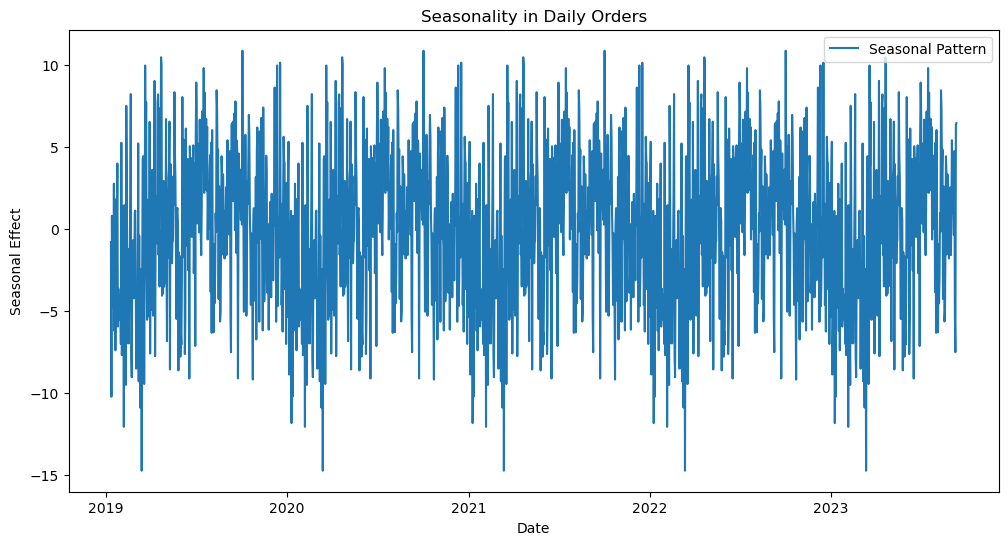

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
# Perform seasonal decomposition using 'period' parameter
complete_date_range = pd.date_range(daily_orders['created_at_day'].min(), daily_orders['created_at_day'].max())
daily_orders_reindexed = daily_orders.set_index('created_at_day').reindex(complete_date_range).fillna(0).reset_index().rename(columns={'index': 'created_at_day'})
result = seasonal_decompose(daily_orders_reindexed['order_count'], period=365, model='additive')  # using a yearly frequency
seasonal = result.seasonal

# Plotting the seasonality
plt.figure(figsize=(12, 6))
plt.plot(daily_orders_reindexed['created_at_day'], seasonal, label='Seasonal Pattern')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.title('Seasonality in Daily Orders')
plt.legend()
plt.show()


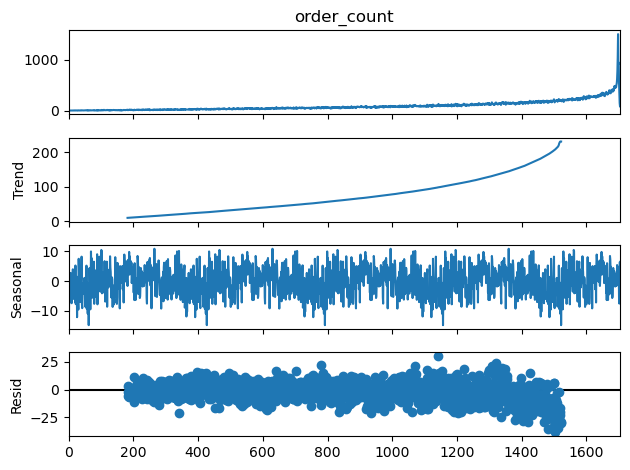

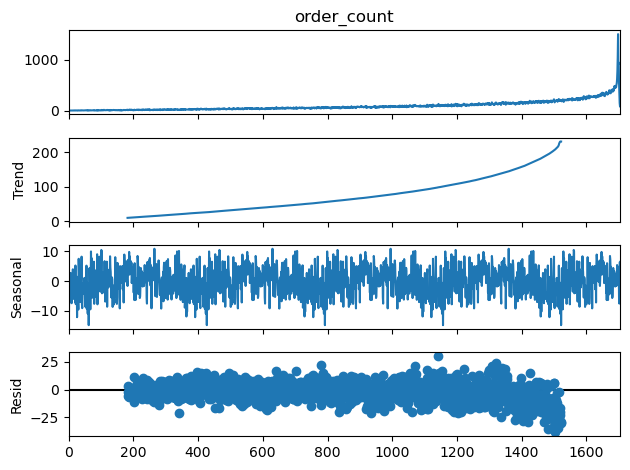

In [56]:
result.plot()

In [43]:
import numpy as np
# Find dominant period through FFT
dominant_period = quick_inspector.fast_fourier_transform(merged_df, 'sales')
print(f"Dominant period: {dominant_period}")


# Initialize default N
N = 7

# Check if dominant_period is finite
if np.isfinite(dominant_period):
    # Run rolling stats only if dominant_period is finite
    is_mean_stable, is_var_stable = quick_inspector.rolling_stats(merged_df, 'sales', window=int(dominant_period))
    
    # Update N based on rolling stats
    if not (is_mean_stable and is_var_stable):
        N = int(dominant_period)

print(f"Optimal N: {N}")


Dominant period: inf
Optimal N: 7


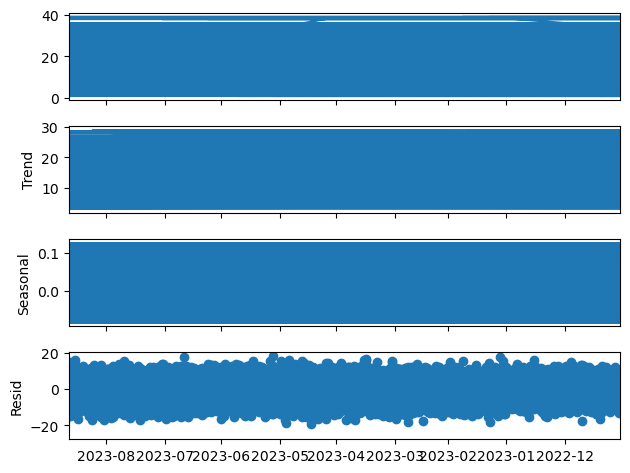

In [46]:
inspector.plot_decomposition(merged_df, 'created_at', 'sales',30)

In [ ]:
from src.data.feature_engineering import FeatureEngineeringProcess
fep = FeatureEngineeringProcess()


In [ ]:
merged_df_fe1 = fep.price_sales_correlation_features_updated(merged_df, 7, [(-5.0, 1.0), (-3.0, 1.0), (-2.0, 1.0), (1.0, 1.0), (-1.0, 0.5), (-1.0, 0.33)],
                                                             'sku', 'created_at', 'sale_price', 'sales')

In [ ]:
from src.data.eda import Eda
eda = Eda()

In [ ]:
eda.missing_values_table(merged_df_fe1)

In [ ]:
# handle missing values in price_sales_correlation 
cols_to_fill_zero = [col for col in merged_df_fe1.columns if 'f_corr_' in col]
merged_df_fe1[cols_to_fill_zero] = merged_df_fe1[cols_to_fill_zero].fillna(0)


In [ ]:
# Drop uneccesary date columns 
merged_df_fe1.drop(columns=['shipped_at', 'delivered_at', 'returned_at'], inplace=True)

In [ ]:
eda.missing_values_table(merged_df_fe1)

In [ ]:
merged_df_fe2 =  fep.normalize_features(merged_df_fe1, [5, 10, 15], 28, 'sku', 'created_at', 'sale_price', 'sales')

In [ ]:
eda.missing_values_table(merged_df_fe2)

In [ ]:
# drop columns with 100% missing values
merged_df_fe2.dropna(axis=1, how='all', inplace=True)


In [ ]:
eda.missing_values_table(merged_df_fe2)

In [ ]:
normalized_cols = [col for col in merged_df_fe2.columns if 'normalized_' in col]
merged_df_fe2[normalized_cols] = merged_df_fe2[normalized_cols].fillna(method='ffill').fillna(method='bfill')


In [ ]:
eda.missing_values_table(merged_df_fe2)

In [ ]:
merged_df_fe3, insuficient_data = fep.filter_stability_periods(merged_df_fe2, 7, 0.04, sku_column='sku', date_column='created_at', price_column='sale_price')

In [ ]:
eda.missing_values_table(merged_df_fe3)

In [ ]:
merged_df_fe3.head()

In [ ]:
## embeddings
from src.data.embeddings import EmbeddingModel
import torch
from sklearn.preprocessing import LabelEncoder
#merged_df_embeddings = merged_df_fe3.copy()


label_encoders = {}
for col in ['category', 'name', 'brand', 'department']:
    le = LabelEncoder()
    merged_df_fe3[col] = le.fit_transform(merged_df_fe3[col])
    label_encoders[col] = le

embedding_dims = [(merged_df_fe3[col].max() + 1, int((merged_df_fe3[col].max() + 1) ** 0.5)) for col in ['category', 'name', 'brand', 'department']]
model = EmbeddingModel(embedding_dims)




#preapre data for embeddings
cat_data = merged_df_fe3[['category', 'name', 'brand', 'department']].values
cat_data_tensor = torch.tensor(cat_data, dtype=torch.long)


In [ ]:
import torch.nn as nn
sales_data = merged_df_fe3['sales'].values
sales_data_tensor = torch.tensor(sales_data, dtype=torch.float32).view(-1, 1)

import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10  # Number of training epochs

for epoch in range(epochs):
    # Forward pass
    outputs = model(cat_data_tensor)
    
    # Compute loss
    loss = criterion(outputs, sales_data_tensor)

    # Zero gradients, backward pass, optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [ ]:

with torch.no_grad():
    embeddings = model.forward(cat_data_tensor).numpy()


In [ ]:
eda.missing_values_table(merged_df_fe3)

In [ ]:
# Reset Index Before Concatenating
merged_df_fe3.reset_index(drop=True, inplace=True)
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.reset_index(drop=True, inplace=True)
merged_df_embeddings = pd.concat([merged_df_fe3, embeddings_df], axis=1)


In [ ]:
# check lenghts
assert len(merged_df_fe3) == len(embeddings_df), "Dataframes have different lengths."


In [ ]:
eda.missing_values_table(merged_df_embeddings)

In [ ]:
#merged_df_embeddings = pd.concat([merged_df_fe3, pd.DataFrame(embeddings)], axis=1)
#merged_df_embeddings.drop(['category', 'name', 'brand', 'department'], axis=1, inplace=True)


In [ ]:
import numpy as np
# Create a correlation matrix to check for multicollinearity
corr_matrix = merged_df_embeddings.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Features to drop: {to_drop}")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Drop non-numeric columns for VIF calculation
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = merged_df_embeddings.select_dtypes(include=numerics)


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = new_df.columns

vif_data["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]

# Identify features with a high VIF value
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()

print(f"Features with high VIF should be removed or examined: {high_vif_features}")



In [ ]:
print(to_drop)
print(high_vif_features)

In [ ]:
train_dataset = merged_df_embeddings.drop(columns=['f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_1.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33', 222], axis=1)

In [ ]:
# drop categorical features used in embeddings

train_dataset = train_dataset.drop(columns=['category', 'name', 'brand', 'department'], axis=1)

In [ ]:
train_dataset  =  fep.datetime_transform(train_dataset,'created_at', ['day_of_the_year'])


In [ ]:
train_dataset.status.unique()
# drop skus with status "Returned" and "Cancelled"
train_dataset = train_dataset.query('status != "Returned" and status != "Cancelled"')


In [ ]:
# use label encoder for status and gender


train_dataset['status'] = le.fit_transform(train_dataset['status'])
train_dataset['gender'] = le.fit_transform(train_dataset['gender'])



In [ ]:
train_dataset.sort_values(by=['created_at'], inplace=True)

In [ ]:
# print first and last date
print(train_dataset.created_at.min())
print(train_dataset.created_at.max())


In [ ]:
from typing import Dict, Union
import pandas as pd

def describe_time_series(df: pd.DataFrame, date_column: str, sales_column: str) -> Dict[str, Union[int, Dict[int, Dict[str, int]]]]:
    """
    Function to provide a comprehensive description of the time series data.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the time series data.
    - date_column (str): Column name containing the date information.
    
    Returns:
    - Dict: Description containing number of years, months per year, and average sales per month.
    """

    # Convert date column to datetime if not already
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract year and month from date
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month

    # Initialize results dictionary
    result = {
        "total_years": 0,
        "years_detail": {}
    }

    # Total number of unique years
    total_years = df['year'].nunique()
    result["total_years"] = total_years

    # Iterate over each year to find details
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        
        # Number of unique months in this year
        unique_months = year_data['month'].nunique()
        
        # Average sales per month
        avg_sales_per_month = year_data.groupby('month')[sales_column].mean().to_dict()

        # Add details to result
        result['years_detail'][year] = {
            "unique_months": unique_months,
            "avg_sales_per_month": avg_sales_per_month
        }

    return result

# Example usage (assuming 'merged_df' contains 'date' and 'sales' columns)
# describe_time_series(merged_df, 'date')






In [ ]:
describe_time_series(train_dataset, 'created_at', 'sales')

In [ ]:
# print min and max date
print(train_dataset.created_at.min())
print(train_dataset.created_at.max())

In [ ]:
# First localize to UTC and then convert to naive datetime
train_dataset['created_at'] = pd.to_datetime(train_dataset['created_at'], utc=True).dt.tz_localize(None)

# Check unique dates and data types after conversion
print("Unique dates after conversion:", train_dataset['created_at'].unique())
print("Data type after conversion:", train_dataset['created_at'].dtype)



In [ ]:

from src.data.data_splitter import DataSplitter


data_splitter = DataSplitter(train_dataset, 'sales','sku', 'created_at', 36, 6, 4)
X_train, y_train, X_val, y_val, X_test, y_test = data_splitter.split_data()

In [ ]:
print('X_val info', X_val.info())
print('X_train info', X_train.info())

In [ ]:
X_train.head()

In [ ]:
# drop 'sku', 'year', 'month' from X_train and X_val
X_train.drop(columns=['sku', 'year', 'month'], inplace=True)
X_val.drop(columns=['sku', 'year', 'month'], inplace=True)

X_test.drop(columns=['year', 'month'], inplace=True)

In [ ]:
# drop column "36" from X_train and X_val
X_train.drop(columns=[36], inplace=True)
X_val.drop(columns=[36], inplace=True)
X_test.drop(columns=[36], inplace=True)


In [ ]:
from src.train.quantile_training import DemandCurveTrainer
trainer = DemandCurveTrainer(X_train, y_train, X_val, y_val,  tune_params=True)
trainer.train_models()
trainer.evaluate_models()
#trainer.plot_feature_importance()
# Predict demand curve (Assume test_data is prepared with SKUs and prices)
sku_demand_curves, demand_curve_pricing, price_points_per_sku = trainer.predict_demand_curve(X_test, 'sku', 'sale_price')


In [ ]:
import plotly.express as px
import pandas as pd


def plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku):
    # Create the DataFrame properly
    data = []
    for sku, sku_demand_curve in sku_demand_curves.items():
        if sku == selected_sku:  # Only proceed if the SKU matches
            for q, demand_predictions in sku_demand_curve.items():
                for price, prediction in zip(price_points_per_sku[sku], demand_predictions):
                    data.append({'SKU': sku, 'Price Points': price, 'Predicted Sales': prediction, 'Quantile': f'Quantile {q}'})
    
    df = pd.DataFrame(data)
    
    # Create the Plotly figure for the selected SKU
    fig = px.line(df, x='Price Points', y='Predicted Sales', color='Quantile',
                  title=f'Demand Curve for SKU: {selected_sku}',
                  labels={'Price Points': 'Price Points', 'Predicted Sales': 'Predicted Sales'})
    fig.show()

In [ ]:
plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku="0129A222FE10C9896DB191C537694699")

In [ ]:
from src.train.quantile_training import DemandCurveTrainer
trainer = DemandCurveTrainer(X_train, y_train, X_val, y_val,  tune_params=True)
trainer.plot_feature_importance()